# Timeseries Forecasting of Cryptocurrency Prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of cryptocurrencies such as bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/XRP USD Historical Data.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 11, 2018",2.09436,1.94415,2.26700,1.54000,40.02M,9.08
1,"Jan 10, 2018",1.92000,2.05000,2.11800,1.61320,30.46M,-5.91
2,"Jan 09, 2018",2.04055,2.40000,2.48100,1.90000,18.91M,-14.98
3,"Jan 08, 2018",2.40000,2.77067,2.77067,1.91111,20.76M,-13.36
4,"Jan 07, 2018",2.77000,2.65000,2.81000,2.56000,9.10M,4.53


In [3]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1074,"Feb 02, 2015",0.01424,0.01424,0.01424,0.01424,0,0.00
1075,"Feb 01, 2015",0.01424,0.01455,0.01455,0.01419,0.10K,-2.13
1076,"Jan 31, 2015",0.01455,0.01649,0.01649,0.01448,1.22K,-11.76
1077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,NaN,Highest:3.28000,Lowest:0.00211,Difference:3.27789,Average:0.09488,"Change %:12,600.78085",NaN


In [4]:
data.dropna(axis=0, inplace=True)
data = data.iloc[::-1]

In [5]:
from pandas import datetime
data['Date'] = data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
data['Price'] = data['Price'].apply(lambda x: atof(x))

In [7]:
data['Open'] = data['Open'].apply(lambda x: atof(x))
data['High'] = data['High'].apply(lambda x: atof(x))
data['Low'] = data['Low'].apply(lambda x: atof(x))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 1076 to 0
Data columns (total 7 columns):
Date        1077 non-null datetime64[ns]
Price       1077 non-null float64
Open        1077 non-null float64
High        1077 non-null float64
Low         1077 non-null float64
Vol.        1077 non-null object
Change %    1077 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 67.3+ KB


## Visualizing prices for the whole dataset

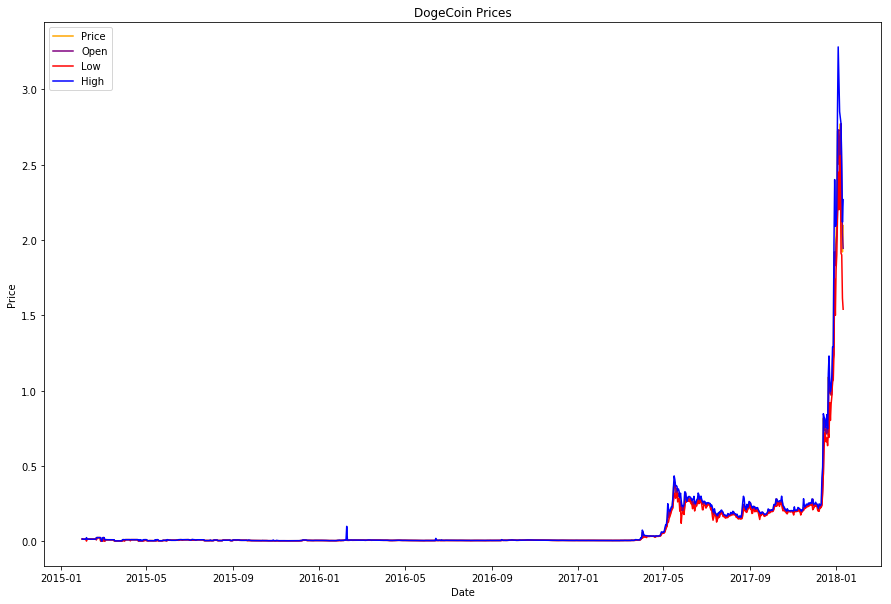

In [9]:
plt.plot(data['Date'], data['Price'], color = 'orange')
plt.plot(data['Date'], data['Open'], color='purple')
plt.plot(data['Date'], data['Low'], color='red')
plt.plot(data['Date'], data['High'], color='blue')
plt.title('DogeCoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.savefig('./data/historical_prices.png')

## Using TensorFlow to Train RNNs

In [10]:
import tensorflow as tf

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [11]:
data = data.set_index('Date')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1077 entries, 2015-01-31 to 2018-01-11
Data columns (total 6 columns):
Price       1077 non-null float64
Open        1077 non-null float64
High        1077 non-null float64
Low         1077 non-null float64
Vol.        1077 non-null object
Change %    1077 non-null float64
dtypes: float64(5), object(1)
memory usage: 58.9+ KB


### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
price_data_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

### Creating a Dataset with Features

In [16]:
def create_dataset(timeseries, n_inputs=30):
    
    features = []
    targets = []
    
    for i in range(len(timeseries) - n_inputs):
        
        start = i
        end = start + n_inputs
        
        x = timeseries[start:end]
        y = timeseries[end]
        
        features.append(x)
        targets.append(y)
    
    return np.array(features), np.array(targets)

In [17]:
X, y = create_dataset(price_data_scaled, n_inputs=14)

In [18]:
X.shape

(1063, 14, 1)

In [19]:
percent_training = 0.75
num_samples = X.shape[0]
num_train = int(percent_training * num_samples)

X_train, y_train = X[:num_train], y[:num_train]
X_test, y_test = X[num_train:], y[num_train:]

## Training the RNN Model

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

num_inputs = 14

model = Sequential()
model.add(LSTM(100, input_shape=(num_inputs, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Using TensorFlow backend.


In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=1, epochs=100, callbacks=[early_stopping])

Train on 797 samples, validate on 266 samples
Epoch 1/100
797/797 [==============================] - 10s 12ms/step - loss: 8.1222e-06 - mean_absolute_error: 0.0016 - val_loss: 0.0377 - val_mean_absolute_error: 0.1133
Epoch 2/100
797/797 [==============================] - 9s 11ms/step - loss: 4.4758e-06 - mean_absolute_error: 0.0013 - val_loss: 0.0405 - val_mean_absolute_error: 0.1181
Epoch 3/100
797/797 [==============================] - 9s 12ms/step - loss: 4.3597e-06 - mean_absolute_error: 0.0012 - val_loss: 0.0413 - val_mean_absolute_error: 0.1186
Epoch 4/100
797/797 [==============================] - 9s 11ms/step - loss: 4.3640e-06 - mean_absolute_error: 0.0012 - val_loss: 0.0425 - val_mean_absolute_error: 0.1194


In [22]:
model.save('./models/ripple_model.h5')

### Comparing Generated Predictions with Prices in Testing Set

In [23]:
pred = model.predict(X_test)

In [24]:
pred.shape

(266, 1)

In [25]:
results = scaler.inverse_transform(pred)

In [26]:
num_samples = results.shape[0]
test_data_price = data.iloc[-num_samples:]['Price']

In [27]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index, 
                                     'Price': test_data_price.values, 
                                     'Prediction': results[:, 0]})

In [28]:
test_data_price_pred

,Date,Prediction,Price
0,2017-04-21,0.012968,0.03531
1,2017-04-22,0.013140,0.03477
2,2017-04-23,0.013150,0.03475
3,2017-04-24,0.013152,0.03376
4,2017-04-25,0.013104,0.03504
5,2017-04-26,0.013154,0.03582
6,2017-04-27,0.013199,0.03806
7,2017-04-28,0.013313,0.04784
8,2017-04-29,0.013794,0.05700
9,2017-04-30,0.014314,0.05500


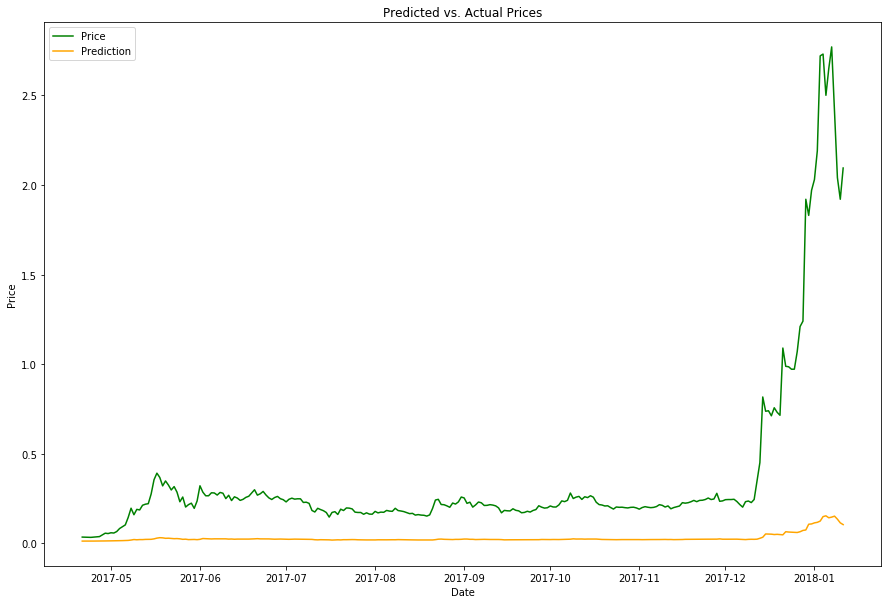

In [29]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.savefig('./data/predictions.png')